In [1]:
%pylab inline

import os
import itertools as it
from scipy.ndimage.filters import gaussian_filter

from tools.stats import err, binner

from styles.paper import *
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def residual_table(residuals, masks, residual_labels, mask_labels, keywords):

    for i in xrange(len(keywords)):
        bias_a, pres_a = [], []
        bias_b, pres_b = [], []
        bias_c, pres_c = [], []
        for mask in masks:
            bias_a.append(median(residuals[0][keywords[i]][mask]))
            pres_a.append(diff(percentile(residuals[0][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_b.append(median(residuals[1][keywords[i]][mask]))
            pres_b.append(diff(percentile(residuals[1][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_c.append(median(residuals[2][keywords[i]][mask]))
            pres_c.append(diff(percentile(residuals[2][keywords[i]][mask], [16,84]))[0]*0.5)

        for j in xrange(len(masks)):
            if j==0:
                print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (residual_labels[i], mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
            else:
                print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
        print r"\hline"

def plot_residual_hist(residuals, labels, keywords, res_lbs, limits=((-0.7, 0.7), (1.3, 3.0)), colors=(samples["light"], samples["dark"]), nbins=15):
    xlm, ylm = limits

    fig, axs = subplots(3, len(keywords), figsize=(7, 4.5), sharex=True, sharey=True)

    axs[0, 0].set_xlim(xlm)
    axs[0, 0].set_xticks([-0.4, 0, 0.4])
    axs[1, 0].set_ylabel(r"\bf $u-r$")

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        x, y, e = binner(lcolor, residuals[i][keywords[j]], nbins, ylm, "median")

        axs[i, j].plot(gaussian_filter(y,1.5), x, "-", color=colors[1], lw=1.5)
        axs[i, j].fill_betweenx(x, gaussian_filter(y-e[0],1.5), gaussian_filter(y+e[1],1.5), facecolor=colors[0], lw=0)

        axs[i, j].axvline(ls=":", color="k", lw=0.7)
        axs[i, j].axhline(2.22, ls=":", color="k", lw=0.7)

        if i==2: axs[i, j].set_xlabel(res_lbs[keywords[j]])
        if j==0:
            axs[i, j].text(0.1, 0.9, labels[i], fontsize="xx-small", ha="left", transform=axs[i, j].transAxes)

    axs[1, 0].set_ylim(x[0], x[-1])

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05)
    
    return None

In [3]:
#load outputs from S/N tests

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws]

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kws = [field.rstrip("_mod") for field in fields]

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

#high-S/N test (S/N=999.9 for all spectral resolutions)
sdss_hsn = genfromtxt("../inputs/proof_biasless/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws]
jpas_hsn = genfromtxt("../inputs/proof_biasless/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws]
spec_hsn = genfromtxt("../inputs/proof_biasless/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws]

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

sdss_hsn["M_mod"] = log10(sdss_hsn["M_mod"])
jpas_hsn["M_mod"] = log10(jpas_hsn["M_mod"])
spec_hsn["M_mod"] = log10(spec_hsn["M_mod"])

#compute residuals and discrepancies
sdss_res_hsn = dict(
    M=err(ssag_tta["M_lib"], sdss_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_hsn["Av_mod"], False)
)
jpas_res_hsn = dict(
    M=err(ssag_tta["M_lib"], jpas_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_hsn["Av_mod"], False)
)
spec_res_hsn = dict(
    M=err(ssag_tta["M_lib"], spec_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_hsn["Av_mod"], False)
)

In [4]:
residual_table([spec_res_hsn,jpas_res_hsn,sdss_res_hsn], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)

\multirow{3}{*}{\dlogm}   &      SFGs &    -0.003 &     0.056 & &    -0.001 &     0.056 & &     0.113 &     0.188\\
                          &      PaGs &    -0.003 &     0.049 & &     0.000 &     0.051 & &     0.164 &     0.117\\
                          & All Gals. &    -0.003 &     0.054 & &    -0.000 &     0.054 & &     0.143 &     0.166\\
\hline
\multirow{3}{*}{\dmwla}   &      SFGs &     0.008 &     0.112 & &     0.020 &     0.120 & &     0.176 &     0.374\\
                          &      PaGs &    -0.003 &     0.055 & &     0.001 &     0.074 & &     0.206 &     0.151\\
                          & All Gals. &     0.003 &     0.088 & &     0.016 &     0.098 & &     0.191 &     0.289\\
\hline
\multirow{3}{*}{\dlwla}   &      SFGs &     0.026 &     0.054 & &     0.021 &     0.081 & &     0.149 &     0.219\\
                          &      PaGs &     0.004 &     0.052 & &     0.008 &     0.062 & &     0.089 &     0.189\\
                          & All Gals. &     0.017 &     0.

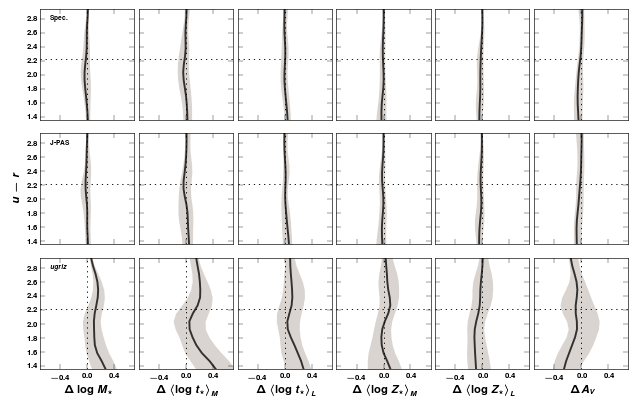

In [5]:
plot_residual_hist((spec_res_hsn, jpas_res_hsn, sdss_res_hsn), labels=(r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"), keywords=kws, res_lbs=Delta)